# Customer Support Bot Using OpenAI Swarm with Azure AI Search and Azure OpenAI
[Farzad S.](https://www.linkedin.com/in/farzadsunavala/)

This notebook demonstrates how to create a customer support bot using OpenAI's Swarm framework and Azure AI Search as a tool for function calling along with Azure OpenAI. The bot consists of two agents:

1. **User Interface Agent**: Handles initial user interactions and transfers users to the Help Center Agent.
2. **Help Center Agent**: Provides detailed help using Azure AI Search and can perform actions like submitting tickets and sending emails.

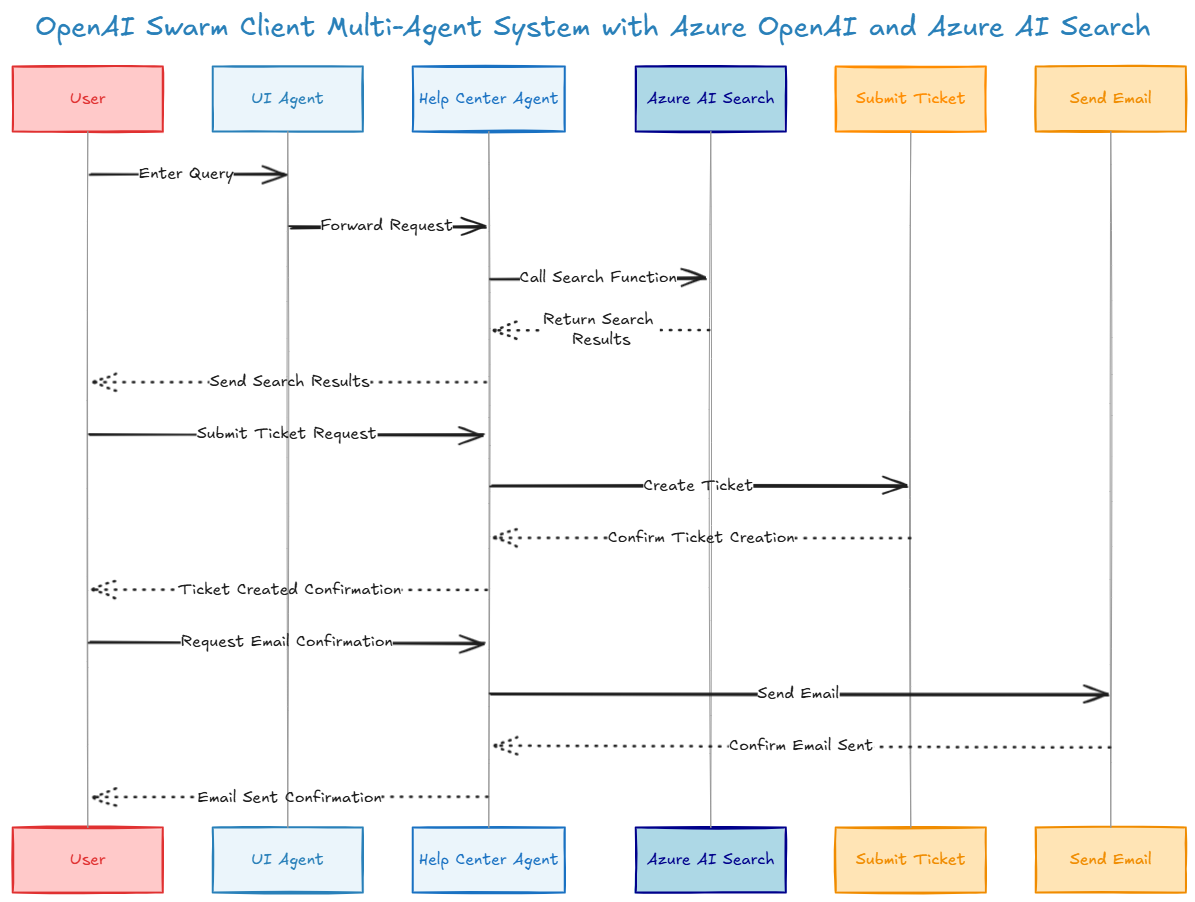

### Prerequisites

1. **Python 3.1** or higher
2. **OpenAI Swarm** library installed
3. **Azure OpenAI** or **OpenAI** access with appropriate models deployed
4. **Azure AI Search index** index named `azure-search-docs` populated with the Azure AI Search documentation
5. **Azure OpenAI API key**
6. **Azure AI Search service endpoint and API key**
---

For indexing the documentation, you can do this super quick: 
1. Go to https://learn.microsoft.com/azure/search/
2. Click "Download PDF" in the bottom left
3. Go to the Azure AI Search servicei in the Azure Portal.
4. Go to Blob Storage and create a container and upload the azure-search.pdf document to a container
4. Click "Import and Vectorize" and go through the wizard
5. Wait for the indexer to complete and verify you see a search index with "`title`, `chunk`, and `text_vector` fields" (all you need for this notebook)


## Setup
### 1. Install Required Packages

In [ ]:
# Install OpenAI Swarm and Azure Search SDK
!pip install git+https://github.com/openai/swarm.git
!pip install azure-search-documents==11.6.0b6

### 2. Import Libraries

In [3]:
from swarm import Swarm, Agent
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from openai import AzureOpenAI
import json
import re
import os

### 3. Configure API Credentials

In [4]:
# Azure OpenAI API configuration
aoai_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2024-09-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Azure AI Search configuration
search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")    # Replace with your Azure AI Search endpoint
search_api_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")      # Replace with your Azure AI Search API key
index_name = "azure-search-docs"            # Replace with your Azure AI Search index name

### 4. Initialize Azure AI Search Client

In [5]:
# Initialize the Azure AI Search client
credential = AzureKeyCredential(search_api_key)
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=index_name,
    credential=credential
)

### 5. Initialize Swarm Client

In [6]:
# Initialize Swarm client with Azure OpenAI client
swarm_client = Swarm(client=aoai_client)


---

## Define Functions with Print Statements for Logging
### 1. `query_docs` Function
This function searches the Azure AI Search index for relevant documents using the Hybrid + Semantic Reranking retrieval mode.

In [56]:
import re
from azure.search.documents import SearchClient
from azure.search.documents.models import (
    QueryLanguage,
    QueryType,
    VectorizableTextQuery,
)
from azure.core.credentials import AzureKeyCredential

def query_docs(query: str):
    """
    Query the knowledge base for relevant articles using vector search.
    Returns all relevant chunks without truncation.
    """
    print(f"[Function Call] query_docs called with query: '{query}'")
    
    # Create a vectorizable text query
    vector_query = VectorizableTextQuery(
        text=query,
        k_nearest_neighbors=3,
        fields="text_vector"  # Ensure this field matches your index's vector field
    )
    
    # Perform the search with semantic ranking
    results = search_client.search(
        search_text=query,
        vector_queries=[vector_query],
        query_type=QueryType.SEMANTIC,
        query_language=QueryLanguage.EN_US,
        semantic_configuration_name="azure-search-docs-semantic-configuration",  # Ensure this matches your configuration
        top=3,  # Number of results to retrieve
    )
    
    output = []
    
    for result in results:
        # Adjust 'Title', 'chunk', and 'url' to match your index's field names
        title = result.get("title", "No Title")
        content = result.get("chunk", "No Content")
        url = result.get("url", "No URL")
        output.append((title, content, url))
    
    if output:
        response_parts = []
        for idx, (title, content, url) in enumerate(output, start=1):
            part = f"**Result {idx}:**\n**Title:** {title}\n**Content:** {content}\n**URL:** {url}\n"
            response_parts.append(part)
            print(f"[Function Output] Result {idx} processed.")
        
        response = "\n".join(response_parts)
        print(f"[Function Return] query_docs returning response with {len(output)} results.")
        return {"response": response}
    else:
        print("[Function Output] No results found in the knowledge base.")
        print("[Function Return] query_docs returning 'No results found.'")
        return {
            "response": "I'm sorry, but I couldn't find any information on that topic in our knowledge base."
        }


### 2. `submit_ticket` Function
Simulates submitting a support ticket.

In [50]:
def submit_ticket(description: str):
    """
    Submit a ticket for the user.
    """
    print(f"[Function Call] submit_ticket called with description: '{description}'")
    # Simulate ticket submission logic here
    print(f"[Function Output] Ticket created with description: '{description}'")
    print(f"[Function Return] submit_ticket returning response.")
    return {"response": f"Your ticket has been created with the description: '{description}'."}


### 3. `send_email` Function
Simulates sending an email to the user.

In [51]:
def send_email(email_address: str = None, message: str = "Your support ticket has been submitted.", context_variables: dict = {}):
    """
    Send an email to the user.
    """
    if not email_address:
        email_address = context_variables.get("email_address", None)
        if not email_address:
            print("[Function Output] Email address not provided.")
            print("[Function Return] send_email returning 'Email address not provided.'")
            return {"response": "Email address not provided."}
    # Simulate sending an email
    print(f"[Function Call] send_email called with email_address: '{email_address}' and message: '{message}'")
    print(f"[Function Output] Email sent to: {email_address} with message: {message}")
    print(f"[Function Return] send_email returning response.")
    return {"response": f"The email has been sent to {email_address}."}


### 4. `transfer_to_help_center` Function
Transfers the user to the Help Center Agent.

In [53]:
def transfer_to_help_center():
    """
    Transfer the user to the help center agent.
    """
    print("[Function Call] transfer_to_help_center called.")
    print("[Function Output] Transferring to Help Center Agent.")
    print("[Function Return] transfer_to_help_center returning Help Center Agent.")
    return help_center_agent


---
## Define Agents
### 1. Help Center Agent

In [52]:
help_center_agent = Agent(
    name="Help Center Agent",
    instructions="""
You are a help center agent who assists users with questions about our products and services.
Use the provided functions to help the user:

- Use `query_docs` to search for information.
- Use `submit_ticket` to create a support ticket for the user.
- Use `send_email` to send an email to the user.

**Important:** Before performing any action, ensure you fully understand the user's request. If needed, ask clarifying questions to gather all necessary details.

When you need to use a function, call it directly.
""",
    functions=[query_docs, submit_ticket, send_email],
    model='gpt-4o-mini'  # Replace with your Azure OpenAI deployment ID
)


### 2. User Interface Agent

In [54]:
user_interface_agent = Agent(
    name="User Interface Agent",
    instructions="""
You are a user interface agent that handles all interactions with the user.
For detailed help, transfer the user to the Help Center Agent using the transfer_to_help_center function.
""",
    functions=[transfer_to_help_center],
    model='gpt-4o-mini'  # Replace with your Azure OpenAI deployment ID
)

---
## Multi Agent Interaction Loop 

In [55]:
# Initialize context variables
context_variables = {"name": "Farzad", "user_id": 12345}

# Initialize messages and set the starting agent
messages = []
agent = user_interface_agent  # Start with the User Interface Agent

def pretty_print_messages(messages):
    for message in messages:
        if message.get("content") is None:
            continue
        sender = message.get("sender", message.get("role", "assistant"))
        print(f"{sender.capitalize()}: {message['content']}")

def is_valid_email(email: str) -> bool:
    pattern = r"[^@]+@[^@]+\.[^@]+"
    return re.match(pattern, email) is not None

# Interaction loop with print-based logging
print("You can start chatting with the assistant. Type 'exit' or 'quit' to end the conversation.")
try:
    while True:
        user_input = input("> ")
        print(f"User Input: {user_input}")  # Logging user input
        if user_input.lower() in ["exit", "quit"]:
            print("Assistant: Goodbye!")
            break

        messages.append({"role": "user", "content": user_input})

        # Check if the user provided an email address
        if is_valid_email(user_input):
            context_variables["email_address"] = user_input.strip()
            # Inform the assistant that the email address has been provided
            messages.append({"role": "system", "content": f"User email address is {user_input.strip()}"})

        response = swarm_client.run(
            agent=agent,
            messages=messages,
            context_variables=context_variables
        )
        # Update messages with the new messages from the response
        messages.extend(response.messages)
        # Update agent if there's a handoff
        agent = response.agent
        # Update context variables if they have changed
        context_variables.update(response.context_variables)
        # Print the assistant's response
        pretty_print_messages(response.messages[-len(response.messages):])
except KeyboardInterrupt:
    print("\nAssistant: Goodbye!")

You can start chatting with the assistant. Type 'exit' or 'quit' to end the conversation.
User Input: need help with azure search
[Function Call] transfer_to_help_center called.
[Function Output] Transferring to Help Center Agent.
[Function Return] transfer_to_help_center returning Help Center Agent.
Tool: {"assistant": "Help Center Agent"}
Help center agent: Could you please provide more details about what specific assistance you need with Azure Search? Are you looking for setup guidance, troubleshooting, or something else?
User Input: semantic ranker availability in mexico central
[Function Call] query_docs called with query: 'semantic ranker availability in Mexico Central'
[Function Output] Result 1 processed.
[Function Output] Result 2 processed.
[Function Output] Result 3 processed.
[Function Return] query_docs returning response with 3 results.
Tool: {'response': '**Result 1:**\n**Title:** azure-search.pdf\n**Content:** that\'s billed by usage. By default, semantic ranker\nis tur